In [1]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import SCORERS
import pandas as pd
pd.set_option('display.max_rows', 300)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.auto import tqdm
import json

# Historical Analysis of Models 4 and 1b Performance

This notebook continues the analysis of Models 4 and 1b (stated below) from the notebook titled 'Prediction of NFL Scores Using Only Game Results'. Model 4 showed the most potential of the seven models compared. It had significantly lower 5th and 95th quantiles of MSE for the 2019 NFL season game by game analysis. However, it was noted that variance due to multicollinearity may be an issue for the performance of This Model. For this reason, it is compared against Model 1b, which had the second best quantiles. Model 1b does not suffer from multicollinearity, so it is a useful comparison to see if there is significant variance inflation.

##### Statement of Models

- Model 1 b: $ y = \beta_0X_0 + \beta_1X_1 + ... + \beta_{31}X_{31} $<br>
Ridge Regression is performed here, instead of OLS. The loss function in this case is given by: $ ||y - X\beta|| + \alpha||\beta||^2 $, creating a biased estimator for $\beta$. Alpha is determined using an 5-fold validated gridsearch method, where the MSE statistic is being optimised. 
- Model 4: $ y =  \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_{32}X_{32} $<br>
This model includes all dummy variables and the intercept term. Perfect Multicollinearity exists here so OLS Cannot be used since $X$ is not full-rank. Therefore Ridge Regression is used to bias the data. It incorporates a 'home advantage' coefficient ($\beta_0$) as well as a single 'rating' (coefficient) for each team. This model has the added bonus of asymmetry over Model 1.

##### Retrieving the Data

In [2]:
data = pd.read_csv('spreadspoke_scores.csv'
                   , usecols = ['schedule_season', 'team_home', 'score_home', 'score_away', 'team_away'])
data.columns = ['Season', 'Home Team', 'Home Score', 'Away Score', 'Away Team']
data['Goal Diff'] = data['Home Score'] - data['Away Score']
# The analysis will be done over the last 17 years 
data = data[(2002 <= data['Season']) & (data['Season'] <= 2019)].reset_index(drop = True)
display(data.head(), data.tail())

,Season,Home Team,Home Score,Away Score,Away Team,Goal Diff
0,2002,New York Giants,13.0,16.0,San Francisco 49ers,-3.0
1,2002,Buffalo Bills,31.0,37.0,New York Jets,-6.0
2,2002,Carolina Panthers,10.0,7.0,Baltimore Ravens,3.0
3,2002,Chicago Bears,27.0,23.0,Minnesota Vikings,4.0
4,2002,Cincinnati Bengals,6.0,34.0,San Diego Chargers,-28.0


,Season,Home Team,Home Score,Away Score,Away Team,Goal Diff
4801,2019,Green Bay Packers,28.0,23.0,Seattle Seahawks,5.0
4802,2019,Kansas City Chiefs,51.0,31.0,Houston Texans,20.0
4803,2019,Kansas City Chiefs,35.0,24.0,Tennessee Titans,11.0
4804,2019,San Francisco 49ers,37.0,20.0,Green Bay Packers,17.0
4805,2019,Kansas City Chiefs,31.0,20.0,San Francisco 49ers,11.0


##### Train - Test Split Historical Analysis

Setup of the analysis is as follows: A 'year' loop is created to extract the data from each year from 2002 - 2019 (17 years, More years would have been ideal, but the league structure was significantly different before 2002). Within each iteration, a train/test split of the data is created. The two models are trained on the training data, and then a prediction is made on the test data. MSE for each model is then extracted from the discrepency between this prediction and the test data. These results are saved to a dictionary, which is analysed after completion of the main loop.

In [15]:
results = {'noOutliers1b' : [], 'noOutliers4' : [], 'alpha1b' : [], 'alpha4' : [], 'MSE1b' : [], 'MSE4' : []}

for year in tqdm(range(2002, 2020)):
    
    # Data Preprocessing
    seasonData = data[data['Season'] == year].copy().reset_index()
    dfVis = pd.get_dummies(seasonData['Away Team'], dtype=np.int64)
    dfHome = pd.get_dummies(seasonData['Home Team'], dtype=np.int64)
    df = dfHome.sub(dfVis) 
    df['Goal Diff'] = seasonData['Goal Diff']
    X = df.drop('Goal Diff', axis=1)
    y = df['Goal Diff']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Constructing models & Calculating MSE
    param_grid = {'alpha' : np.arange(0.1, 12, 0.01)}
    
    alpha1b = GridSearchCV(Ridge(fit_intercept = False), param_grid, scoring='neg_mean_squared_error', cv=5).fit(
                           X_train, y_train).best_params_['alpha']
    alpha4 = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=5).fit(
                           X_train, y_train).best_params_['alpha']
    
    ridgeMod1b = Ridge(fit_intercept = False, alpha = alpha1b).fit(X_train, y_train)
    ridgeMod4 = Ridge(alpha = alpha4).fit(X_train, y_train)
    
    r1b = y_train - ridgeMod1b.predict(X_train)
    z1b = (r1b - np.mean(r1b))/(np.sum((r1b - np.mean(r1b))**2)/len(y_train))**(1/2)
    z1b = z1b.to_frame()
    z1b.drop(z1b[np.abs(z1b['Goal Diff']) > 3].index, inplace = True)
    newTrainingIndexes1b = z1b.index.tolist()
    results['noOutliers1b'].append(r1b.shape[0] - len(newTrainingIndexes1b))
    
    r4 = y_train - ridgeMod4.predict(X_train)
    z4 = (r4 - np.mean(r4))/(np.sum((r4 - np.mean(r4))**2)/len(y_train))**(1/2)
    z4 = z4.to_frame()
    z4.drop(z4[np.abs(z4['Goal Diff']) > 3].index, inplace = True)
    newTrainingIndexes4 = z4.index.tolist()
    results['noOutliers4'].append(r1b.shape[0] - len(newTrainingIndexes1b))
    
    alpha1bnew = GridSearchCV(Ridge(fit_intercept = False), param_grid, scoring='neg_mean_squared_error', cv=5).fit(
                              X_train.loc[newTrainingIndexes1b,:], y_train[newTrainingIndexes1b]).best_params_['alpha']
    results['alpha1b'].append(alpha1bnew)
    alpha4new = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=5).fit(
                             X_train.loc[newTrainingIndexes4,:], y_train[newTrainingIndexes4]).best_params_['alpha']
    results['alpha4'].append(alpha4new)
    
    ridgeMod1bnew = Ridge(fit_intercept = False, alpha = alpha1bnew)
    ridgeMod1bnew.fit(X_train.loc[newTrainingIndexes1b,:], y_train[newTrainingIndexes1b])
    ridgeMod4new = Ridge(alpha = alpha4new)
    ridgeMod4new.fit(X_train.loc[newTrainingIndexes4,:], y_train[newTrainingIndexes4])
    
    y_pred1b = ridgeMod1bnew.predict(X_test)
    MSE1b = np.mean((y_test - y_pred1b)**2)
    results['MSE1b'].append(MSE1b)
    y_pred4 = ridgeMod4new.predict(X_test)
    MSE4 = np.mean((y_test - y_pred4)**2)
    results['MSE4'].append(MSE4)

print(results)

# saving results to a file so the code above doesn't need to be rerun each time Jupyter is opened.
with open('HistoricalAnalysisYearOnYear.json', 'w') as file:
    json.dump(results, file, indent = 6)
    


{'noOutliers1b': [0, 0, 1, 2, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0], 'noOutliers4': [0, 0, 1, 2, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0], 'alpha1b': [3.649999999999998, 9.229999999999995, 8.109999999999996, 3.839999999999998, 11.869999999999994, 5.959999999999996, 5.679999999999997, 5.819999999999997, 8.759999999999994, 8.369999999999996, 8.789999999999996, 7.019999999999996, 6.849999999999996, 6.959999999999996, 8.299999999999995, 6.0399999999999965, 6.839999999999996, 3.989999999999998], 'alpha4': [3.3399999999999985, 10.179999999999994, 7.349999999999996, 2.649999999999999, 10.659999999999995, 5.819999999999997, 5.589999999999997, 5.599999999999997, 7.649999999999996, 7.179999999999996, 8.269999999999996, 5.939999999999997, 7.349999999999996, 6.719999999999996, 9.339999999999995, 6.139999999999997, 6.6199999999999966, 4.099999999999998], 'MSE1b': [193.34955813412665, 230.69139971643995, 136.77353796004633, 217.82804088566826, 157.84411546829693, 235.01846553194048, 189.682913

##### Displaying Results

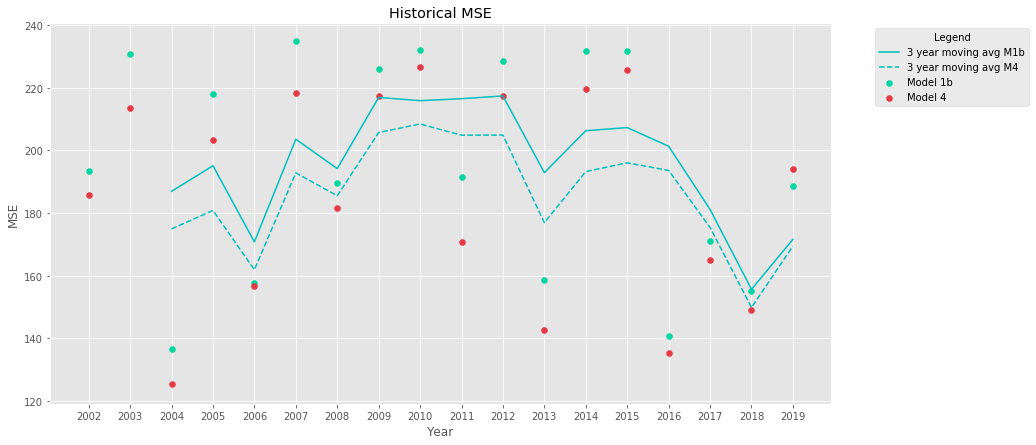

In [3]:
# Opening the results from the json file
with open("HistoricalAnalysisYearOnYear.json", "r") as read_it:
     results = json.load(read_it)

years = np.arange(2002, 2020, 1)

plt.figure(figsize=(14, 7))
plt.scatter(years, results['MSE1b'], color='#06d6a0', label='Model 1b')
plt.scatter(years, results['MSE4'], color='#e63946', label='Model 4')

plt.plot(years, pd.Series(results['MSE1b']).rolling(3).mean(), 'c-', label='3 year moving avg M1b')
plt.plot(years, pd.Series(results['MSE4']).rolling(3).mean(), 'c--', label='3 year moving avg M4')

plt.title('Historical MSE')
plt.ylabel('MSE')
plt.xlabel('Year')
plt.xticks(years)
plt.legend(title = 'Legend', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

The plot above shows that when a train/test spit is used, model 4 out performs model 1 b. Their performances year on year are highly corrolated which is expected, as the only difference between the two models is the fitted intercept. 

However, this plot doesn't show the change in performance of the model over the course of a season, and this is explored next. This is much more computationaly expensive, so the accuracy of the gridsearch is reduced to compensate.

##### Game - by - Game Historical Analysis

In [10]:
results2 = {'predictions1b' : {}, 'outliers1b' : {}, 'predictions4' : {}, 'outliers4'  : {}}

for year in tqdm(range(2002, 2020)):
    
    # Data Preprocessing
    seasonData = data[data['Season'] == year].copy().reset_index()
    dfVis = pd.get_dummies(seasonData['Away Team'], dtype=np.int64)
    dfHome = pd.get_dummies(seasonData['Home Team'], dtype=np.int64)
    df = dfHome.sub(dfVis) 
    df['Goal Diff'] = seasonData['Goal Diff']
    X = df.drop('Goal Diff', axis=1)
    y = df['Goal Diff']
    
    param_grid = {'alpha' : np.arange(0.1, 10, 0.1)}
    results2['predictions1b'][year] = []
    results2['outliers1b'][year] = []
    results2['predictions4'][year] = []
    results2['outliers4'][year] = []
    
    for game in tqdm(range(34, df.shape[0]-1)):
        
        alpha1b = GridSearchCV(Ridge(fit_intercept = False), param_grid
                               , scoring='neg_mean_squared_error', cv=5).fit(
                               X.loc[:game,:], y.loc[:game]).best_params_['alpha']
        ridgeMod1b = Ridge(alpha = alpha1b, fit_intercept = False).fit(X.loc[:game,:], y.loc[:game])

        r1b = y.loc[:game] - ridgeMod1b.predict(X.loc[:game,:])
        z1b = (r1b - np.mean(r1b))/(np.sum((r1b - np.mean(r1b))**2)/len(y.loc[:game]))**(1/2)
        z1b = z1b.to_frame()
        z1b.drop(z1b[np.abs(z1b['Goal Diff']) > 3].index, inplace = True)
        newTrainingIndexes1b = z1b.index.tolist()
        results2['outliers1b'][year].append(len(y.loc[:game]) - len(newTrainingIndexes1b))
        
        alpha1bnew = GridSearchCV(Ridge(fit_intercept = False), param_grid
                                  , scoring='neg_mean_squared_error', cv=5).fit(
                                  X.loc[newTrainingIndexes1b,:], 
                                  y.loc[newTrainingIndexes1b]).best_params_['alpha']
        
        ridgeMod1bnew = Ridge(alpha = alpha1bnew, fit_intercept = False)
        ridgeMod1bnew.fit(X.loc[newTrainingIndexes1b,:], y.loc[newTrainingIndexes1b])
        results2['predictions1b'][year].append(float(ridgeMod1bnew.predict(
                                               X.loc[game+1,:].to_numpy().reshape(1,-1))))

        alpha4 = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=5).fit(
                              X.loc[:game,:], y.loc[:game]).best_params_['alpha']
        ridgeMod4 = Ridge(alpha = alpha4).fit(X.loc[:game,:], y.loc[:game])

        r4 = y.loc[:game] - ridgeMod4.predict(X.loc[:game,:])
        z4 = (r4 - np.mean(r4))/(np.sum((r4 - np.mean(r4))**2)/len(y.loc[:game]))**(1/2)
        z4 = z4.to_frame()
        z4.drop(z4[np.abs(z4['Goal Diff']) > 3].index, inplace = True)
        newTrainingIndexes4 = z4.index.tolist()
        results2['outliers4'][year].append(len(y.loc[:game]) - len(newTrainingIndexes4))
        
        alpha4new = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=5).fit(
                                 X.loc[newTrainingIndexes4,:], 
                                 y.loc[newTrainingIndexes4]).best_params_['alpha']
        
        ridgeMod4new = Ridge(alpha = alpha4new, fit_intercept = False)
        ridgeMod4new.fit(X.loc[newTrainingIndexes4,:], y.loc[newTrainingIndexes4])
        results2['predictions4'][year].append(float(ridgeMod4new.predict(
                                              X.loc[game+1,:].to_numpy().reshape(1,-1))))

with open('HistoricalAnalysisGameOnGame.json', 'w') as file:
    json.dump(results2, file, indent = 6)


##### Extracting Summary Statistics

In [11]:
with open("HistoricalAnalysisGameOnGame.json", "r") as read_it:
     results2 = json.load(read_it)

print(results2)
        
error1b = {}
error4 = {}
meanError1b = []
meanError4 = []
varError1b = []
varError4 = []
quant50_1b = []
quant50_4 = []
quant95_1b = []
quant95_4 = []

for year in range(2002, 2020):
    seasonData = data[data['Season'] == year].copy().reset_index()
    y = seasonData['Goal Diff']
    error1b[year] =  np.abs(y.loc[35:] - np.array(results2['predictions1b'][str(year)]).flatten())
    error4[year] = np.abs(y.loc[35:] - np.array(results2['predictions4'][str(year)]).flatten())
    meanError1b.append(np.mean(error1b[year]))
    meanError4.append(np.mean(error4[year]))
    varError1b.append(np.var(error1b[year]))
    varError4.append(np.var(error4[year]))
    quant50_1b.append(round(np.quantile(error1b[year], .5),3))
    quant50_4.append(round(np.quantile(error4[year], .5),3))
    quant95_1b.append(round(np.quantile(error1b[year], .95),3))
    quant95_4.append(round(np.quantile(error4[year], .95),3)) 


{'predictions1b': {'2002': [4.427957906055855, -8.318604502327968, -1.2376587854824859, 11.215842621503679, -5.9140866914094605, 10.943482777279959, 4.448366486939607, 5.8337383128475215, 2.1412030367699604, -0.6160807868135287, 6.96160648567536, -0.8213611732680134, -3.864956029664498, -17.54310985667733, -16.621225979450365, -5.424564195537881, 10.405194656773295, -9.807285478954507, 5.094198260702219, 13.866093632121554, -3.2581752618636695, -2.4439562815869884, -0.5753825481886259, 3.439489107212048, -8.209177398872143, -5.64659920053699, -12.711453375276072, 0.43119222797975243, 1.1311135172734725, -3.5684577789886243, -9.067403825394118, 15.562467670226706, -4.391135691262466, -1.7198920039053691, 5.257566723704477, -13.850940682135723, 3.2168835926493595, -0.17029265691245365, -1.1271586869290888, -8.277342858227946, -7.2106180320005, -2.946749207519354, -2.806876785486522, 2.180498271253603, -0.7110891347007708, 4.755679042190782, -1.5738875001074586, 2.386729117754105, -13.614

##### Plotting Results

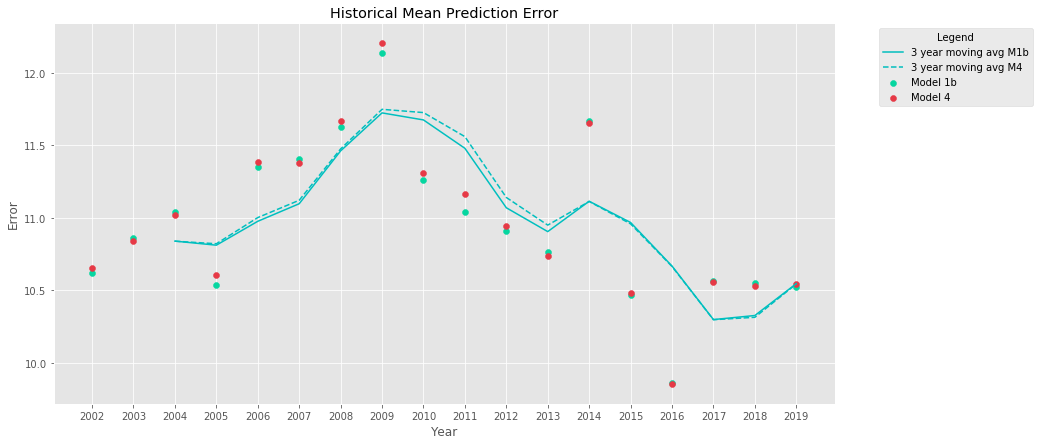

In [12]:
years = np.arange(2002, 2020, 1)

plt.figure(figsize=(14, 7))
plt.scatter(years, meanError1b, color='#06d6a0', label='Model 1b')
plt.scatter(years, meanError4, color='#e63946', label='Model 4')

plt.plot(years, pd.Series(meanError1b).rolling(3).mean(), 'c-', label='3 year moving avg M1b')
plt.plot(years, pd.Series(meanError4).rolling(3).mean(), 'c--', label='3 year moving avg M4')

plt.title('Historical Mean Prediction Error')
plt.ylabel('Error')
plt.xlabel('Year')
plt.xticks(years)
plt.legend(title = 'Legend', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

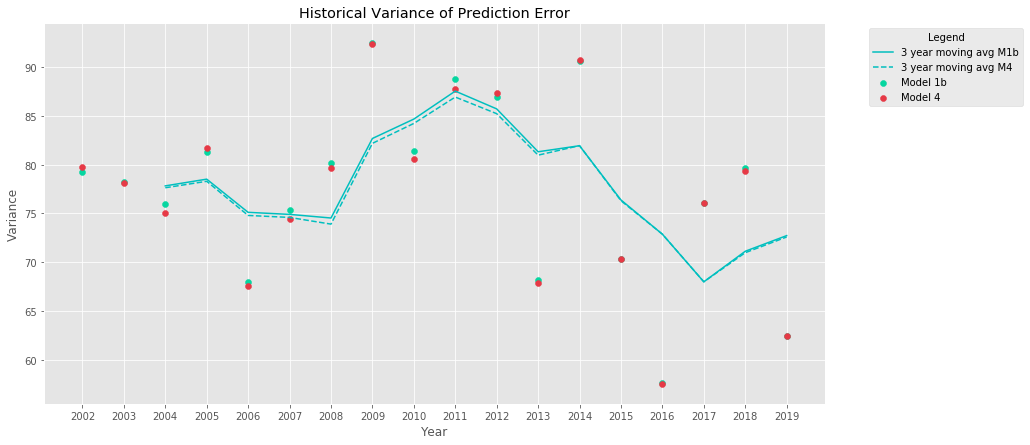

In [13]:
years = np.arange(2002, 2020, 1)

plt.figure(figsize=(14, 7))
plt.scatter(years, varError1b, color='#06d6a0', label='Model 1b')
plt.scatter(years, varError4, color='#e63946', label='Model 4')

plt.plot(years, pd.Series(varError1b).rolling(3).mean(), 'c-', label='3 year moving avg M1b')
plt.plot(years, pd.Series(varError4).rolling(3).mean(), 'c--', label='3 year moving avg M4')

plt.title('Historical Variance of Prediction Error')
plt.ylabel('Variance')
plt.xlabel('Year')
plt.xticks(years)
plt.legend(title = 'Legend', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

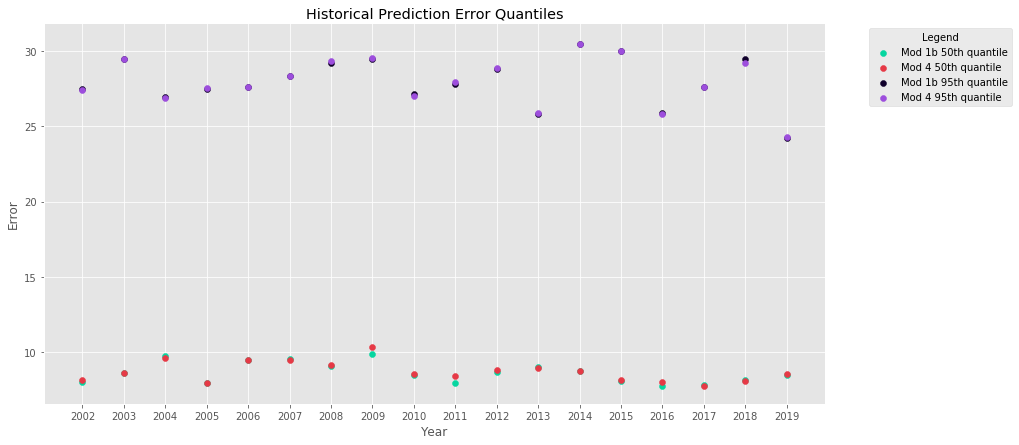

In [14]:
years = np.arange(2002, 2020, 1)

plt.figure(figsize=(14, 7))
plt.scatter(years, quant50_1b, color='#06d6a0', label='Mod 1b 50th quantile')
plt.scatter(years, quant50_4, color='#e63946', label='Mod 4 50th quantile')
plt.scatter(years, quant95_1b, color='#10002b', label='Mod 1b 95th quantile')
plt.scatter(years, quant95_4, color='#9d4edd', label='Mod 4 95th quantile')

plt.title('Historical Prediction Error Quantiles')
plt.ylabel('Error')
plt.xlabel('Year')
plt.xticks(years)
plt.legend(title = 'Legend', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

The performance stats between the two models are similar. This was somewhat surprising given that model 4 outperformed model 1b in the train/test split historical analysis at the beginning of this notebook. Model 1b had, on average, a slightly lower mean prediction error, while model 4 had a slightly lower variance. The third plot showed similar quantiles between the two models, with model 1b tending to have a marginally lower 50th quantile, and a marginally larger 95th. 